## Verificação de Algoritmos

Neste notebook serao testadas tecnicas mais tradicionais para classificacao das mensagens. Testado um treinamento nao supervisionado usando o Spectral Clustering, e tambem um treinamento supervisionado usando alguns algoritmos classificadores.

In [1]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../")

In [2]:
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics.pairwise import (
    cosine_similarity, 
    cosine_distances,
    laplacian_kernel, 
    euclidean_distances, 
    sigmoid_kernel, 
    chi2_kernel,
    polynomial_kernel,
    rbf_kernel
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, v_measure_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import SpectralClustering

from processing.utils import CleanUp, RSLP_STEMMER, SNOWBALL_STEMMER, NLP_LEMMATIZER

%matplotlib inline

clean_up = CleanUp()

In [3]:
df = pd.read_csv(f"{os.getcwd()}/../../data/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

In [4]:
print(random.choice(textos))
print(len(textos))
# print(df[df['x'] == ''].index)
# print(df.loc[250])

['resposta cres rap num sei foi febre amarela uma das outras duas que tomei mesmo dia mas fui parar hospital'
 0]
1044


### Unsupervised Learning : Spectral Clustering

Baseado no paper de referência: [Opinion Mining on Twitter Data using Unsupervised Learning Technique](https://www.ijcaonline.org/archives/volume148/number12/unnisa-2016-ijca-911317.pdf)

In [5]:
validacoes = []
for Vectorizer in [CountVectorizer, TfidfVectorizer]:
    for Norm in [MinMaxScaler, None]:
        for ngram_range in [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3)]:
            vectorizer = Vectorizer(ngram_range=ngram_range)
            X = vectorizer.fit_transform(textos[:, 0]).todense()
            norm_name = None
            if Norm:
                norm_name = Norm.__name__
                X = Norm().fit_transform(X)
            y = textos[:, 1].astype(np.int).ravel()

            for metric in (
                cosine_similarity, 
                cosine_distances,
                laplacian_kernel, 
                euclidean_distances, 
                sigmoid_kernel, 
                chi2_kernel,
                polynomial_kernel,
                rbf_kernel
            ):
                for assign_labels in ["discretize", "kmeans"]:
                    clustering = SpectralClustering(
                        n_clusters=2,
                        eigen_solver="amg",
                        assign_labels=assign_labels,
                        affinity="precomputed_nearest_neighbors",
                        random_state=0,
                        n_jobs=-1
                    ).fit(metric(X))

                    pred = clustering.labels_
                    acc = round(accuracy_score(pred, y) * 100, 2)
                    f1 = round(f1_score(pred, y) * 100, 2)
                    vm = round(v_measure_score(y, pred), 2)
                    silhouette = None
                    try:
                        silhouette = silhouette_score(metric(X), pred, metric="precomputed")
                    except:
                        pass
                    validacoes.append((
                        vectorizer.__class__.__name__,
                        norm_name,
                        ngram_range,
                        metric.__name__,
                        assign_labels,
                        acc, 
                        f1,
                        vm,
                        silhouette
                    ))

In [6]:
columns = ["Vectorizer", "Scaler", "NGram", "Metric", "AssignLabels", "Accuracy", "F1", "V-Measure", "Silhouette"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "V-Measure", "Silhouette", "Vectorizer", "Metric"], ascending=False)
df.reset_index().head(25)

,Vectorizer,Scaler,NGram,Metric,AssignLabels,Accuracy,F1,V-Measure,Silhouette
299,TfidfVectorizer,None,"(2, 3)",chi2_kernel,kmeans,44.06,57.31,0.01,NaN
293,TfidfVectorizer,None,"(2, 3)",laplacian_kernel,kmeans,43.77,57.31,0.01,NaN
315,TfidfVectorizer,None,"(3, 3)",chi2_kernel,kmeans,41.09,56.60,0.00,NaN
309,TfidfVectorizer,None,"(3, 3)",laplacian_kernel,kmeans,40.33,56.59,0.00,NaN
63,CountVectorizer,MinMaxScaler,"(2, 3)",rbf_kernel,kmeans,40.42,56.56,0.00,NaN
197,TfidfVectorizer,MinMaxScaler,"(1, 3)",laplacian_kernel,kmeans,39.46,56.53,0.00,NaN
213,TfidfVectorizer,MinMaxScaler,"(2, 3)",laplacian_kernel,kmeans,39.46,56.53,0.00,NaN
203,TfidfVectorizer,MinMaxScaler,"(1, 3)",chi2_kernel,kmeans,39.46,56.53,0.00,NaN
235,TfidfVectorizer,MinMaxScaler,"(3, 3)",chi2_kernel,kmeans,39.46,56.53,0.00,NaN
69,CountVectorizer,MinMaxScaler,"(3, 3)",laplacian_kernel,kmeans,39.85,56.51,0.00,NaN


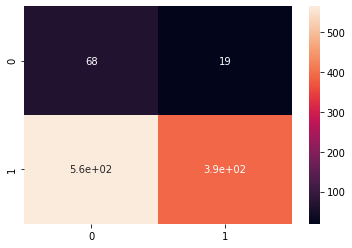

In [45]:
vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X = vectorizer.fit_transform(textos[:, 0]).todense()
# X = MinMaxScaler().fit_transform(X)
y = textos[:, 1].astype(np.int).ravel()

clustering = SpectralClustering(
    n_clusters=2,
    eigen_solver="amg",
    assign_labels="kmeans",
    affinity="precomputed_nearest_neighbors",
    random_state=0,
    n_jobs=-1
).fit(chi2_kernel(X))

pred = clustering.labels_
df_cm = confusion_matrix(pred, y)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True)
plt.show()

### Supervised Learning

Parcialmente baseado no paper: [Towards detecting influenza epidemics by analyzing Twitter messages](https://dl.acm.org/doi/pdf/10.1145/1964858.1964874)

In [8]:
classifiers = [
    LogisticRegression(
        random_state=0,
        n_jobs=-1
    ), 
    RidgeClassifier(
        max_iter=500,
        random_state=0,
    ),
    SGDClassifier(
        random_state=0,
        n_jobs=-1,
        max_iter=1500,
        n_iter_no_change=10
    ), 
    SVC(
        kernel="linear",
        random_state=0
    ),
    MLPClassifier(
        learning_rate_init=1e-2,
        random_state=0
    )
]

validacoes = []
for Vectorizer in [CountVectorizer, TfidfVectorizer]:
    for Norm in [None]: # [MinMaxScaler, StandardScaler, None]:
        for ngram_range in [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3)]:
            vectorizer = Vectorizer(ngram_range=ngram_range)
            X = vectorizer.fit_transform(textos[:, 0]).todense()
            norm_name = None
            if Norm:
                norm_name = Norm.__name__
                X = Norm().fit_transform(X)
            y = textos[:, 1].astype(np.int).ravel()

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
            for Classifier in classifiers:
                clf = Classifier.fit(X_train, y_train)
                pred = clf.predict(X_test)

                acc = round(accuracy_score(pred, y_test) * 100, 2)
                f1 = round(f1_score(pred, y_test) * 100, 2)
                validacoes.append((
                    vectorizer.__class__.__name__,
                    norm_name,
                    ngram_range,
                    clf.__class__.__name__,
                    acc, 
                    f1
                ))

In [9]:
columns = ["Vectorizer", "Scaler", "NGram", "Classifier", "Accuracy", "F1"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "Vectorizer", "NGram"], ascending=False)
df.reset_index().head(25)

,Vectorizer,Scaler,NGram,Classifier,Accuracy,F1
127,TfidfVectorizer,None,"(1, 1)",SGDClassifier,74.52,69.70
61,CountVectorizer,None,"(1, 3)",RidgeClassifier,71.97,69.66
60,CountVectorizer,None,"(1, 3)",LogisticRegression,73.57,69.60
56,CountVectorizer,None,"(1, 2)",RidgeClassifier,71.97,69.44
55,CountVectorizer,None,"(1, 2)",LogisticRegression,72.61,69.06
53,CountVectorizer,None,"(1, 1)",SVC,70.70,67.83
63,CountVectorizer,None,"(1, 3)",SVC,70.38,67.82
128,TfidfVectorizer,None,"(1, 1)",SVC,74.52,66.94
58,CountVectorizer,None,"(1, 2)",SVC,70.06,66.90
0,CountVectorizer,MinMaxScaler,"(1, 1)",LogisticRegression,71.66,66.67


Acc: 71.66
F1 : 59.73


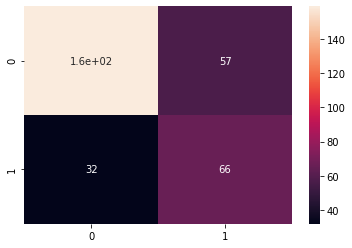

In [44]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
X = vectorizer.fit_transform(textos[:, 0]).todense()
#X = MinMaxScaler().fit_transform(X)
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = SGDClassifier(
    random_state=0,
    n_jobs=-1,
    max_iter=1500,
    n_iter_no_change=20
).fit(X_train, y_train)
pred = clf.predict(X_test)

acc = round(accuracy_score(pred, y_test) * 100, 2)
f1 = round(f1_score(pred, y_test) * 100, 2)
print("Acc:", acc)
print("F1 :", f1)

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True)
plt.show()